<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:150%; text-align:left">  

<p style="background-color: #009688; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Fine-Tuning GPT-2 for Story Generation</p>  

GPT-2 is a transformer-based language model with 1.5 billion parameters, trained on a dataset comprising 8 million web pages. Its primary objective is to predict the next word based on preceding text, enabling it to learn patterns, structures, and diverse language tasks naturally. This extensive dataset exposure allows GPT-2 to perform a variety of NLP tasks without explicit fine-tuning.  

### **Zero-Shot Transfer Learning**  

GPT-2 is pre-trained solely on language modeling, meaning it does not undergo task-specific fine-tuning. Instead, it generalizes well across different NLP tasks by predicting conditional probabilities. Without additional training, GPT-2 can generate text, summarize content, translate languages, and even answer questions with remarkable fluency. However, for domain-specific applications, fine-tuning is necessary to enhance its ability to generate more relevant and high-quality outputs.  

### **Fine-Tuning GPT-2 for Story Generation**  

In this notebook, GPT-2 is fine-tuned on a dataset containing writing prompts and corresponding stories, sourced from [this research work](https://github.com/pytorch/fairseq/tree/master/examples/stories). The objective is to train the model to generate coherent and contextually relevant stories that align with the provided prompts.  

Fine-tuning involves training the model on this dataset with adjusted hyperparameters, optimizing it for creative story generation. Techniques such as padding, truncation, and label shifting are applied to ensure proper training data formatting. The model is trained using a suitable optimizer and learning rate to achieve better convergence.  

### **Evaluation Metric: Perplexity**  

To assess the effectiveness of fine-tuning, **perplexity** is used as a performance metric. Perplexity measures how well the model predicts the next word in a sequence—the lower the perplexity score, the better the model’s predictive accuracy. This metric helps determine improvements in model performance after fine-tuning.  

Additionally, qualitative evaluation through human judgment is considered to compare generated stories before and after fine-tuning. By analyzing sentence coherence, logical flow, and creativity, the model's improvements in storytelling capabilities can be assessed.  

This study aims to explore the impact of fine-tuning on GPT-2’s ability to generate engaging, high-quality stories and contribute to advancements in AI-generated creative writing.  

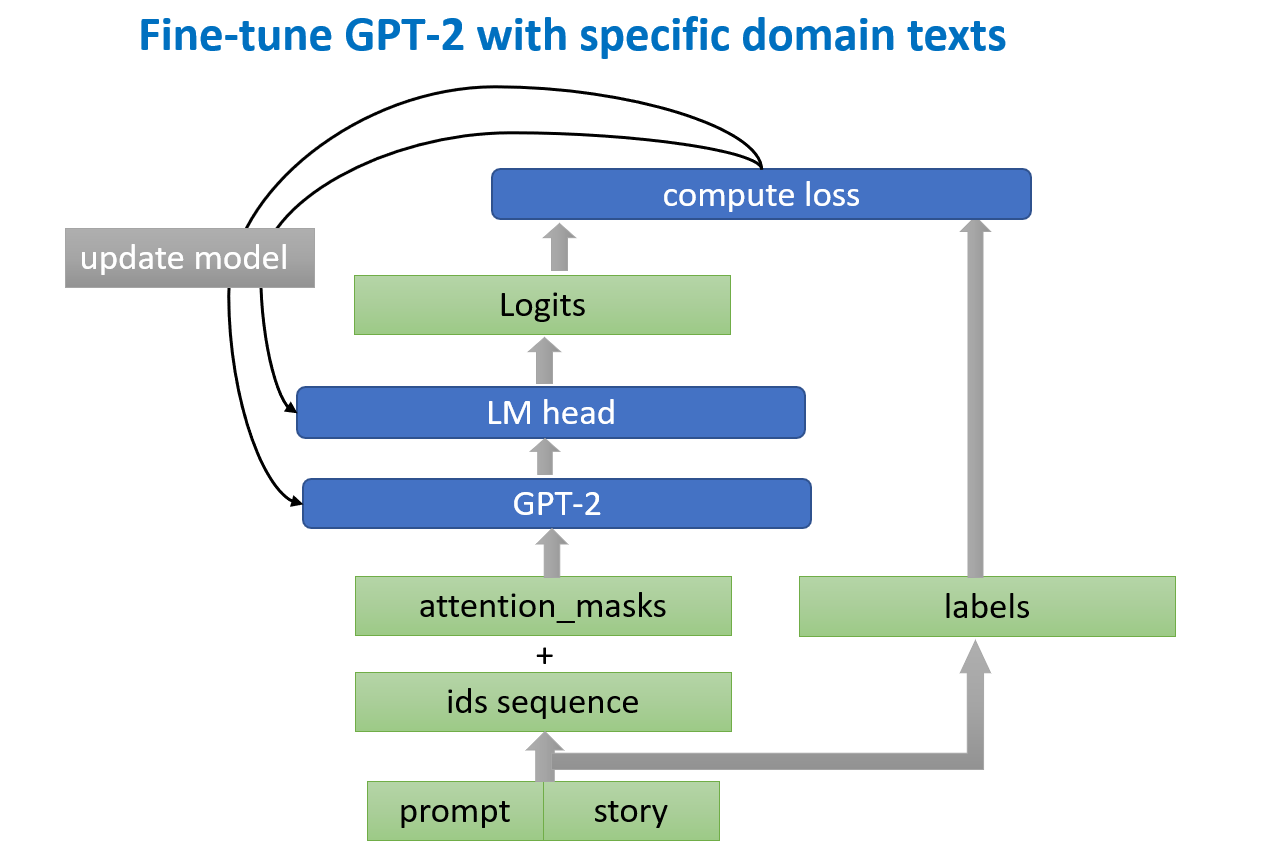

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import logging
from tqdm import tqdm
import math
import argparse
import os

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">

## 1.1 Pacakges and frameworks

**Environment**: Kaggle Python 3 environment and GPU

**Deep learning framework**: Pytorch

**NLP Package**: Transformers 3.0.2

In [2]:
!git clone https://github.com/huggingface/transformers
!pip install transformers/
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers.optimization import AdamW, get_linear_schedule_with_warmup

Cloning into 'transformers'...
remote: Enumerating objects: 258907, done.
remote: Counting objects: 100% (835/835), done.
remote: Compressing objects: 100% (393/393), done.
remote: Total 258907 (delta 644), reused 443 (delta 441), pack-reused 258072 (from 4)
Receiving objects: 100% (258907/258907), 269.37 MiB | 30.72 MiB/s, done.
Resolving deltas: 100% (190875/190875), done.
Processing ./transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.50.0.dev0-py3-none-any.whl size=10849200 sha256=da3c2066914d5a12a29c210e51fe8c824e38f6cc7e3df22bd89248b04be239fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-5lnt1a6x/wheels/7e/b2/24/0b3be37b3b423a6f2fd25fd6368a1f4b0888942789c7e68bc6
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
    

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">
    
## 1.2 Arguments

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=88888)
parser.add_argument("--model_name", default="gpt2", type=str)
parser.add_argument("--max_seq_length", default=512, type=int)
parser.add_argument("--train_batch_size", default=4, type=int)
parser.add_argument("--valid_batch_size", default=4, type=int)
parser.add_argument("--num_train_epochs", default=1, type=int)
parser.add_argument("--warmup", default=0.1, type=float)
parser.add_argument("--learning_rate", default=5e-5, type=float)
parser.add_argument("--input_text_path", default='../input/story-text', type=str)
args, _ = parser.parse_known_args()

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">
    
# 2. Preparing the Data  

## 2.1 Combining Prompts and Stories with Text Cleaning  

The text file is downloaded from the provided link. The original dataset consists of training, validation, and test sets, with prompts and stories stored in separate files. For example, `valid.wp_source` contains writing prompts, while `valid.wp_target` contains corresponding stories.  

Since the training dataset is very large and Kaggle notebooks have a 3-hour kernel runtime limit, the validation dataset is used as the training set, and the test dataset is used as the validation set.  

To enable GPT-2 to process prompts and stories together, they are combined into a single sequence. Each line in the merged file contains a prompt followed by its corresponding story.

In [4]:
DATAPATH=args.input_text_path
def combinetext(prompt, story):
    fp=open(os.path.join(DATAPATH,prompt),encoding='utf8')
    fs=open(os.path.join(DATAPATH,story),encoding='utf8')
    prompts=fp.readlines()
    stories=fs.readlines()
    assert len(prompts)==len(stories)
    combine=[]
    for i in range(len(prompts)):
        combine.append(prompts[i].rstrip()+' <sep> '+" ".join(stories[i].split()[:300]))
    return combine

#do a littel text clean with punctuations
def cleanpunctuation(s):
    for p in '!,.:;?':
        s=s.replace(' '+p,p)
    s=s.replace(' '+'n\'t','n\'t')
    s=s.replace(' '+'\'s','\'s')
    s=s.replace(' '+'\'re','\'re')
    s=s.replace(' '+'\'ve','\'ve')
    s=s.replace(' '+'\'ll','\'ll')
    s=s.replace(' '+'\'am','\'am')
    s=s.replace(' '+'\'m','\'m')
    s=s.replace(' '+'\' m','\'m')
    s=s.replace(' '+'\'m','\'m')
    s=s.replace(' '+'\' ve','\'ve')
    s=s.replace(' '+'\' s','\'s')
    s=s.replace('<newline>','\n')
    return s   

train_text=combinetext('valid.wp_source', 'valid.wp_target')
train_text=list(map(cleanpunctuation,train_text))
valid_text=combinetext('test.wp_source', 'test.wp_target')
valid_text=list(map(cleanpunctuation,valid_text))

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">
    
The below is an example of a prompt and story. 

In [5]:
train_text[6]

"[ WP ] Everyone in the world has magic with various levels of mastery over it. You are extremely powerful with almost no control so you find a demon that's very weak but extremely good at controlling his powers. <sep> `` Imagine you're in a field. '' Green extends in all directions. `` You're alone, the earth is flat, and the blue sky touches the horizon. '' Blue shoots from the ground, arcing overhead. `` The sun appears, tiny in the sky. '' There's a bright light, rays casting shadow behind me. `` What color is it? '' \n \n `` Yellow. '' It burns so brightly, winking playfully. \n \n `` Good. '' She licks her chapped lips, the sound distorting my tiny sun's light. `` Look ahead of you. There's a sheep. '' Something soft and downy wanders across the green, its shadow stretching far beyond the horizon. `` What color is it? '' \n \n My brows crease. `` Uh- '' \n \n `` What color is it? '' \n \n The green wavers. Baa baa black sheep, have you any wool? `` Uh. '' Mary had a little lamb, 

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">
    
## 2.2 Tokenization and Data Loading  

GPT-2 utilizes Byte Pair Encoding (BPE) for tokenizing text sequences. BPE merges frequently co-occurring byte pairs in a greedy manner. To ensure that all sequences in a batch have the same length, the maximum sequence length is set to 512. Longer sequences are truncated, while shorter ones are padded.  

The tokenizer function returns only `input_ids` and `attention_mask`. For training purposes, label sequences (targets) need to be provided to the model. A label sequence is created for each `input_ids` sequence, with padding tokens set to `-100` to exclude them from loss computation. Additionally, GPT-2 automatically shifts the labels to the right to align with `input_ids`, eliminating the need for manual adjustments.

In [6]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token=tokenizer.eos_token

inputs_train = tokenizer(train_text, padding=True,truncation=True,max_length=args.max_seq_length)
inputs_valid=tokenizer(valid_text, padding=True,truncation=True,max_length=args.max_seq_length)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [7]:
def create_labels(inputs):
    labels=[]
    for ids,attention_mask in zip(inputs['input_ids'],inputs['attention_mask']):
        label=ids.copy()
        real_len=sum(attention_mask)
        padding_len=len(attention_mask)-sum(attention_mask)
        label[:]=label[:real_len]+[-100]*padding_len
        labels.append(label)
    inputs['labels']=labels
    
create_labels(inputs_train)
create_labels(inputs_valid)


<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">
    
An example of sequence of input_ids, attention_mask and labels.

In [8]:
print(inputs_train['input_ids'][6])
print(inputs_train['attention_mask'][6])
print(inputs_train['labels'][6])


[58, 28993, 2361, 11075, 287, 262, 995, 468, 5536, 351, 2972, 2974, 286, 30677, 625, 340, 13, 921, 389, 4457, 3665, 351, 2048, 645, 1630, 523, 345, 1064, 257, 3222, 326, 338, 845, 4939, 475, 4457, 922, 379, 12755, 465, 5635, 13, 1279, 325, 79, 29, 7559, 18450, 345, 821, 287, 257, 2214, 13, 10148, 3469, 14582, 287, 477, 11678, 13, 7559, 921, 821, 3436, 11, 262, 4534, 318, 6228, 11, 290, 262, 4171, 6766, 18105, 262, 17810, 13, 10148, 4518, 20611, 422, 262, 2323, 11, 610, 2259, 16965, 13, 7559, 383, 4252, 3568, 11, 7009, 287, 262, 6766, 13, 10148, 1318, 338, 257, 6016, 1657, 11, 24823, 13092, 9082, 2157, 502, 13, 7559, 1867, 3124, 318, 340, 30, 10148, 220, 198, 220, 198, 7559, 12550, 13, 10148, 632, 20246, 523, 35254, 11, 266, 8040, 711, 2759, 13, 220, 198, 220, 198, 7559, 4599, 13, 10148, 1375, 300, 3378, 607, 442, 6320, 11914, 11, 262, 2128, 1233, 24707, 616, 7009, 4252, 338, 1657, 13, 7559, 6803, 4058, 286, 345, 13, 1318, 338, 257, 15900, 13, 10148, 13742, 2705, 290, 866, 88, 11569, 36

In [9]:
class StoryDataset:
    def __init__(self, inputs):
        self.ids = inputs['input_ids']
        self.attention_mask = inputs['attention_mask']
        self.labels=inputs['labels']

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, item):

        return [torch.tensor(self.ids[item], dtype=torch.long),
                torch.tensor(self.attention_mask[item], dtype=torch.long),
                torch.tensor(self.labels[item], dtype=torch.long)]
            

In [10]:
train_batch_size=args.train_batch_size
valid_batch_size=args.valid_batch_size
traindata=StoryDataset(inputs_train)
train_dataloader = torch.utils.data.DataLoader(
    traindata,
    shuffle=False,
    batch_size=train_batch_size)

validdata=StoryDataset(inputs_valid)
valid_dataloader = torch.utils.data.DataLoader(
    validdata,
    shuffle=False,
    batch_size=valid_batch_size)

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">
    
# 3. Model and Optimizer  

## 3.1 Zero-Shot Story Generation  

With the powerful `transformers` package, the pretrained GPT-2 model can be easily downloaded. **Before fine-tuning, the model is evaluated on the validation dataset, yielding an average perplexity score of 39**. The impact of fine-tuning on the perplexity score will be examined later.

In [11]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [12]:
model.to('cuda')
model.eval()
eval_loss=[]
for inputs in tqdm(valid_dataloader, desc="eval"):
    d1,d2,d3=inputs
    d1=d1.to('cuda')        
    d2=d2.to('cuda')
    d3=d3.to('cuda')

    with torch.no_grad():
        output = model(input_ids=d1, attention_mask=d2,labels=d3)
        batch_loss=output[0]
    eval_loss+=[batch_loss.cpu().item()]
    del batch_loss
eval_loss=np.mean(eval_loss)
perplexity=math.exp(eval_loss)
print(f'The average perplexity for valid dataset before fine-tuning is {perplexity}') 

eval: 100%|██████████| 3785/3785 [05:57<00:00, 10.60it/s]

The average perplexity for valid dataset before fine-tuning is 39.27880758112622


<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">
    
A prompt from the validation dataset is selected and input into the model to generate a 300-word story. The generated stories are of high quality. The model’s built-in `generate` method is used for text generation. This method supports various decoding strategies, including greedy decoding, beam-search decoding, and different sampling techniques. The key arguments and their meanings are as follows:  

1) **do_sample**: If set to `False`, greedy decoding is used.  
2) **temperature**: Controls the randomness of token selection by modulating next-token probabilities.  
3) **top_k**: Specifies the number of highest probability vocabulary tokens to retain for top-k filtering.  
4) **top_p**: Defines the cumulative probability threshold for nucleus sampling, keeping the most likely tokens.  
5) **repetition_penalty**: Adjusts the penalty for repeated words, with values between 1.0 (no penalty) and infinity.

In [13]:
prompt=valid_text[300][:valid_text[300].find('<sep>')]
target=valid_text[300][valid_text[300].find('<sep>')+5:]

def generate_story(prompt,target,k=0,p=0.9,output_length=300,temperature=1,num_return_sequences=3,repetition_penalty=1.0):
    print("====prompt====\n")
    print(prompt+"\n")
    print('====target story is as below===\n')
    print(target+"\n")
    encoded_prompt = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt")
    model.to('cpu')
    model.eval()
    output_sequences = model.generate(
        input_ids=encoded_prompt,
        max_length=output_length,
        temperature=temperature,
        top_k=k,
        top_p=p,
        repetition_penalty=repetition_penalty,
        do_sample=True,
        num_return_sequences=num_return_sequences
    )
    if len(output_sequences.shape) > 2:
        output_sequences.squeeze_()
    for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
        print("=== GENERATED SEQUENCE {} ===".format(generated_sequence_idx + 1))
        generated_sequence = generated_sequence.tolist()
        # Decode text
        text = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True)
        # Remove all text after eos token
        text = text[: text.find(tokenizer.eos_token)]
        print(text)

generate_story(prompt,target)

====prompt====

Children's logic dictates the way the world works. [ WP ] 

====target story is as below===

 “ That ’ s not an option I ’ m currently willing to exercise. ” 
 
 I pinch the bridge of my nose to stave off the headache building behind my eyes. If this goes on much longer, I ’ m gon na have to start to start cutting back on the vegetables. 
 
 “ She ’ s dangerous, Jimmy. You know that. You ’ ve seen it. Dealt with it first hand. She just doesn ’ t play by anyone ’ s rules. ” 
 
 Ali finished off her sucker and unwrapped a fresh one, offering it to me. I declined. I ’ d sworn off the things after my third cavity scare. That one saw me at the dentist for the third time in as many months. I don ’ t care what my dad says, I know that guy is evil. Who owns a drill like that? A murderer, that ’ s who. I still hear the damn thing in my nightmares. 
 
 While she savored the smooth flavor of blue-raspberry, I pondered her words. We both knew she was right. The situation was spiral

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


=== GENERATED SEQUENCE 1 ===
Children's logic dictates the way the world works. [ WP ] ___________________________________________ Thuch is not to be confused with Märtschen.[wp] [LA (subject) is a unique technique, when applied to something that the morphology of the object in question, e.g., a gyre, is most often used by an art form (e.g., a "grass"). It is often held that for a creature to fly, its muscles must take on the form of legs or other semi-technical movements. For some organisms this body part takes on the form of a tendons, ligaments, etc., hence the word "leg," etc., but such an extrapolation is often considered a double jeopardy as even the concept of "legs" bears similarity to notions of cat- or duck-like limbs or hands.[-SL] Even without the same conceptual concepts, only the confusion over which "leg" can be shown to come from which species can safely be considered "kennel." Some of the most famous examples, such as the traditional toon wedge, also belong to new "god

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">
    
## 3.1 Fine-Tune the Model  

The dataset consists of 15,620 training samples. Using a single GPU, training the model for one epoch took approximately 21 minutes. **After one epoch of learning, the perplexity for the validation dataset is around 24**, which is an improvement compared to the score before fine-tuning.

In [14]:
num_train_epochs = args.num_train_epochs
training_steps_per_epoch=len(train_dataloader)
total_num_training_steps = int(training_steps_per_epoch*num_train_epochs)
weight_decay=0
learning_rate=args.learning_rate
adam_epsilon=1e-8
warmup_steps=int(total_num_training_steps*args.warmup)
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": weight_decay,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_num_training_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
print("***** Running training *****")
print("  Total_num_training_step = {}".format(total_num_training_steps))
print("  Num Epochs = {}".format(num_train_epochs))
print(f"  Train_batch_size per device = {train_batch_size}")
print(f"  Valid_batch_size per device = {valid_batch_size}")
model.to('cuda')
for epoch in range(num_train_epochs):
    print(f"Start epoch{epoch+1} of {num_train_epochs}")
    train_loss=0
    epoch_iterator = tqdm(train_dataloader,desc='Iteration')
    model.train()
    model.zero_grad()    
    for _, inputs in enumerate(epoch_iterator):        
        d1,d2,d3=inputs
        d1=d1.to('cuda')
        d2=d2.to('cuda')
        d3=d3.to('cuda')
        output = model(input_ids=d1, attention_mask=d2,labels=d3)
        batch_loss=output[0]
        batch_loss.backward()
        optimizer.step()
        scheduler.step()
        model.zero_grad()
        train_loss+=batch_loss.item()
        epoch_iterator.set_description('(batch loss=%g)' % batch_loss.item())
        del batch_loss
    print(f'Average train loss per example={train_loss/training_steps_per_epoch} in epoch{epoch+1}')    
    print(f'Starting evaluate after epoch {epoch+1}')
    eval_loss=[]    
    model.eval()    
    for inputs in tqdm(valid_dataloader, desc="eval"):
        d1,d2,d3=inputs
        d1=d1.to('cuda')        
        d2=d2.to('cuda')
        d3=d3.to('cuda')
        with torch.no_grad():
            output = model(input_ids=d1, attention_mask=d2,labels=d3)
            batch_loss=output[0]
        eval_loss+=[batch_loss.cpu().item()]
        del batch_loss
    eval_loss=np.mean(eval_loss)
    perplexity=math.exp(eval_loss)
    print(f'Average valid loss per example={eval_loss} in epoch{epoch+1}')    
    print(f'Perplextiy for valid dataset in epoch{epoch+1} is {perplexity}')
    

***** Running training *****
  Total_num_training_step = 3905
  Num Epochs = 1
  Train_batch_size per device = 4
  Valid_batch_size per device = 4
Start epoch1 of 1


(batch loss=2.87721): 100%|██████████| 3905/3905 [21:07<00:00,  3.08it/s]


Average train loss per example=3.2846320297592886 in epoch1
Starting evaluate after epoch 1


eval: 100%|██████████| 3785/3785 [05:57<00:00, 10.59it/s]

Average valid loss per example=3.1828094360220542 in epoch1
Perplextiy for valid dataset in epoch1 is 24.114406356321528


<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">
    
## 3.2 Generate Stories  

The fine-tuned model is used to generate stories with the same prompt that was used before fine-tuning.

In [16]:
prompt=valid_text[300][:valid_text[300].find('<sep>')]
target=valid_text[300][valid_text[300].find('<sep>')+5:]
generate_story(prompt,target)

====prompt====

Children's logic dictates the way the world works. [ WP ] 

====target story is as below===

 “ That ’ s not an option I ’ m currently willing to exercise. ” 
 
 I pinch the bridge of my nose to stave off the headache building behind my eyes. If this goes on much longer, I ’ m gon na have to start to start cutting back on the vegetables. 
 
 “ She ’ s dangerous, Jimmy. You know that. You ’ ve seen it. Dealt with it first hand. She just doesn ’ t play by anyone ’ s rules. ” 
 
 Ali finished off her sucker and unwrapped a fresh one, offering it to me. I declined. I ’ d sworn off the things after my third cavity scare. That one saw me at the dentist for the third time in as many months. I don ’ t care what my dad says, I know that guy is evil. Who owns a drill like that? A murderer, that ’ s who. I still hear the damn thing in my nightmares. 
 
 While she savored the smooth flavor of blue-raspberry, I pondered her words. We both knew she was right. The situation was spiral

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


=== GENERATED SEQUENCE 1 ===
Children's logic dictates the way the world works. [ WP ] 
 
 Satan is the narrator, the black man in his nineties radio with an accent. [ WP ] Satan is the narrator, the black man in his nineties radio with an accent. His father calls him Satan 
 
 Satan is the narrator, the black man in his nineties radio with an accent. 
 Satan is the narrator, the black man in his nineties radio with an accent. He smokes cigarettes as a co-worker, we all do, always, every single day. 
 
 Satan is the narrator, the black man in his nineties radio with an accent. He dresses as another black man, sometimes a green for the guy, he speaks for other black people. 
 
 Satan is the narrator, the black man in his nineties radio with an accent. He serves as the narrator of books, which are often down-to-earth, cheap supplements for kids in middle school. 
 
 Satan is the narrator, the black man in his nineties radio with an accent. He said as much to his co-workers: 
 
 Satan is 

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">
    
# 4. Conclusion  

The experiment demonstrated that fine-tuning GPT-2 with a task-specific dataset improves the perplexity score. However, based on human evaluation, it was not possible to determine which generated story was better. The task of generative language modeling remains highly challenging. Human writing abilities are far more complex than what existing technologies can achieve. There is still a long way to go in this field.